In [ ]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install rudalle==0.0.1rc7 > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 4.10.3 which is incompatible.


In [ ]:
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything

# ruDALL-E Malevich (XL)
## Generate images from text

<img style="text-align:center; display:block;" src="https://huggingface.co/sberbank-ai/rudalle-Malevich/resolve/main/dalle-malevich.jpg" width="200">
"Avocado painting in the style of Malevich"


* Task: `text2image generation`
* Num Parameters: `1.3B`
* Training Data Volume: `120 million text-image pairs`

### Model Description
This is a 1.3 billion parameter model for Russian, recreating OpenAI's [DALL·E](https://openai.com/blog/dall-e/), a model capable of generating arbitrary images from a text prompt that describes the desired result.

The generation pipeline includes ruDALL-E, ruCLIP for ranging results, and a superresolution model.
You can use automatic translation into Russian to create desired images with ruDALL-E.

### How to Use
The easiest way to get familiar with the code and the models is to follow the inference notebook we provide in our [github repo](https://github.com/sberbank-ai/ru-dalle).

In [ ]:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

Downloading:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


In [ ]:
realesrgan = get_realesrgan('x2', device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
ruclip = ruclip.to(device)

Downloading:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

x2 --> ready


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/276M [00:00<?, ?B/s]

vae --> ready


Downloading:   0%|          | 0.00/748k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

ruclip --> ready


### Generation by ruDALL-E:

In [ ]:
text = 'красивая тян из аниме' # eq: beautiful girl from anime
pil_images = []
scores = []

seed_everything(6955)

for top_k, top_p, images_num in [
    (2048, 0.995, 3),
    (1536, 0.99, 3),
    (1024, 0.99, 3),
    (1024, 0.98, 3),
    (512, 0.97, 3),
    (384, 0.96, 3),
    (256, 0.95, 3),
    (128, 0.95, 3),
]:
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
    scores += _scores

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

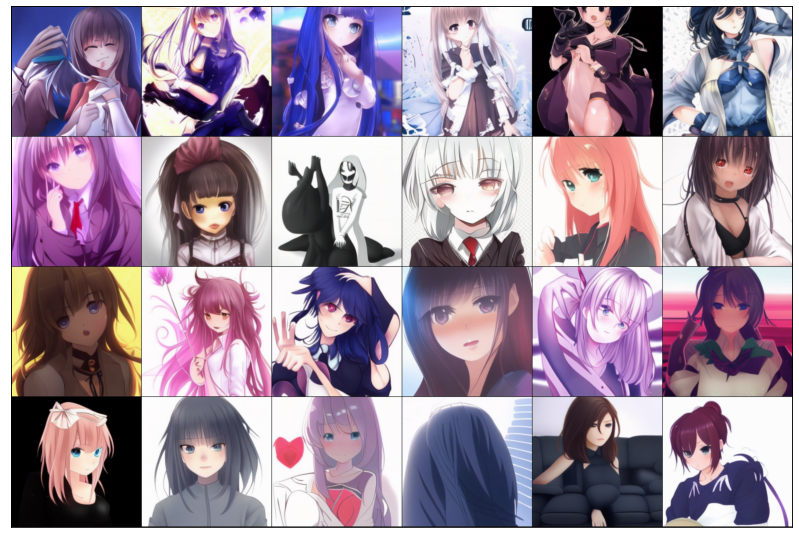

In [ ]:
show(pil_images, 6)

### Auto cherry-pick by ruCLIP:

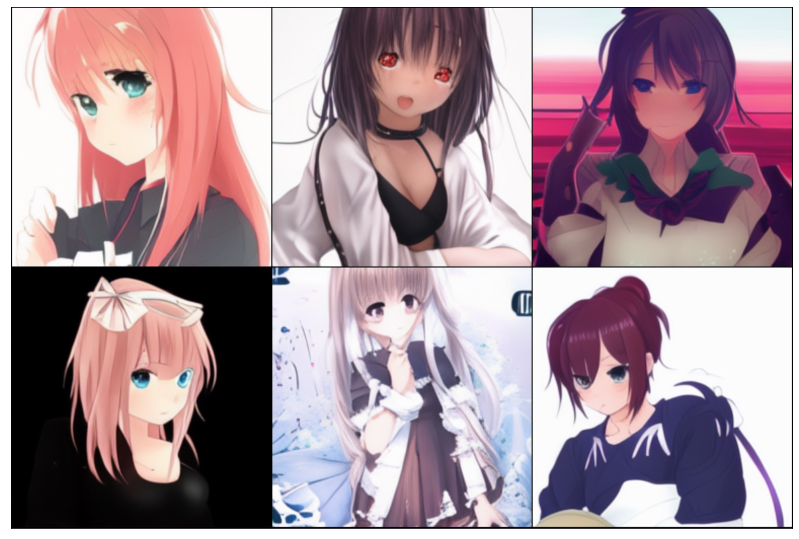

In [ ]:
top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device=device, count=6)
show(top_images, 3)

### Super Resolution:

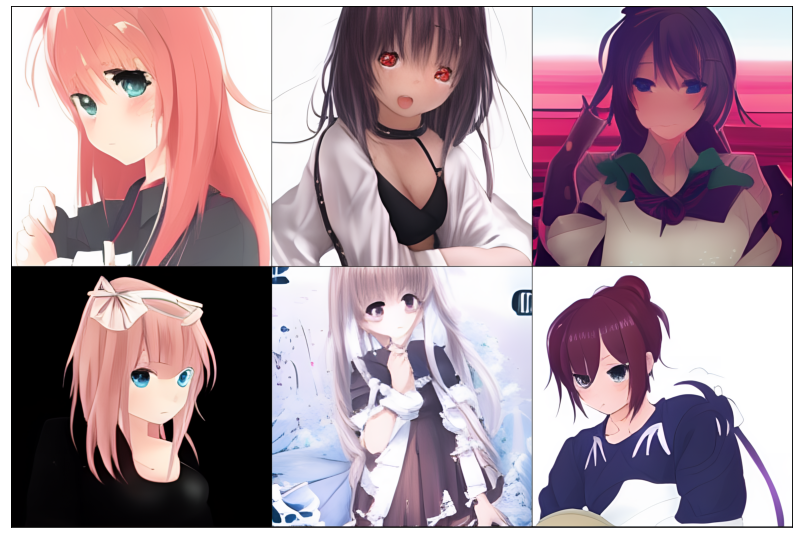

In [ ]:
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 3)